# 1. Introduction
The purpose of this notebook is to assess the profit opportunity of quantile trading strategy based on factors prediction.

Though traditional financial ratios offer valuable insights into a company's financial health, they may not always provide the most timely or comprehensive perspective for quantile trading. A factor-based approach, with its focus on predictive analytics and a broader set of variables, can offer a more dynamic and potentially more profitable strategy for navigating the complexities of the US equity market. Therefore, in this notebook, we will try to construct a dynamic quantile trading strategy based on factor and equity return prediction.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.metrics import r2_score
from seaborn import heatmap
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from pmdarima import auto_arima

import warnings
warnings.filterwarnings('ignore')

from src import *

# 2. Data

We mainly obtain price and financial data from Quandl database (EOD and Zacks). The preprocess of data contains 3 major parts:
1. Universe selection
2. Ratio calculation
3. Return calculation

We then perform exploratory data analysis (EDA) on ratios and factor returns to guide our prediction model construction.

In [2]:
tickers = find_valid_universe()
print(f"Our universe contains {len(tickers)} tickers in total.")

Our universe contains 396 tickers in total.


In [3]:
ratio = calc_ratio(use_cache=True, use_data_cache=True, tickers=tickers
                   ).dropna(how="all", axis=1)
ratio_col = list(set(ratio_col).intersection(ratio.columns))
ratio.shape

(98575, 69)

In [4]:
print(f"Ratio list (n={len(ratio_col)}): {ratio_col}")

Ratio list (n=68): ['excl_exp', 'curr_ratio', 'cash_profit', 'oper_cash_flow_per_share', 'ret_invst', 'V20', 'ebit_margin', 'rev_growth', 'AU', 'ret_6_12', 'VEMA12', 'price_pos', 'AD', 'quantile_95', 'PVO', 'cmo', 'rs_volatility', 'p_volatility', 'Altman_Z_Score', 'DPO', 'rcv_turn', 'win_pct', 'alpha6', 'pretax_profit_margin', 'book_val_per_share', 'asset_turn', 'z_score', 'AR', 'BIASVOL', 'bias', 'day_sale_rcv', 'FI', 'free_cash_flow_per_share', 'skew', 'TURN10', 'ret_1_6', 'volume_shock', 'yz_volatility', 'rd_bias', 'macd', 'tot_debt_tot_equity', 'ret_0_1', 'ret_autocorr', 'free_cash_flow', 'kurt_skew', 'NPR', 'profit_margin', 'pe', 'illiquidity', 'HMA', 'ret_asset', 'gross_margin', 'fluc', 'invty_turn', 'ulcer', 'VSTD20', 'RPPS', 'BR', 'ret_equity', 'K20', 'ERBU', 'lterm_debt_cap', 'ERBE', 'asset_growth', 'DC', 'ret_tang_equity', 'oper_profit_margin', 'alpha12']


In [5]:
factor = calc_factor(use_cache=False, ratio=ratio)
factor.shape

(290, 68)

In [2]:
df_ff = get_ff_data()
df_ff.shape
price = pd.read_pickle("data/price.pkl")["adj_close"].unstack("ticker")

price = fill_price_dates(price, droplevel=False).ffill()
price.shape

(8822, 392)

# 3. Factor Selection

In this part, we select factors by combining IC value and factor return. We rank the IC value and the factor return respectively, and by doing a simple average, we get the rank of all the factors. We choose the largest 10 factors for each month for the following analysis.

The methdology in this part is rather simple, we will try more complex models like GARCH and PCA in the future.

## 3.1. Return Prediction

In this approach, the prediction of factor returns for a given date $i$ is based on a time-weighted moving average of the previous $n$ days' returns. Mathematically, this can be represented as:

$${Predicted Return}_i = \frac{\sum_{j=1}^{n-1} j \times \text{Return}_{i-j}}{\sum_{j=1}^{n-1} j}$$

where $n = 12$, and the weights $w_j$ are assigned linearly such that $w_j = j$ for $j = 1, 2, \ldots, n-1$. This weighting scheme gives more importance to recent returns, with the assumption that they are more indicative of the future return. The sum of the weights is normalized to ensure that the weighted average is properly scaled.

By using this time-weighted moving average method, the model aims to capture the momentum in factor returns, giving more emphasis to recent trends while still considering a historical window of returns. This approach can be particularly useful in financial markets where recent movements may be more relevant for short-term predictions.

In [3]:
ratio = pd.read_pickle('data/ratio.pkl')
factor = pd.read_pickle('data/factor.pkl').shift(1)

In [4]:
def predict_factor_ret(factor,method):
    if method == 'time_weight':
        predicted_factor_ret = time_weight_prediction(factor)
    elif method == 'arima':
        predicted_factor_ret = arima_prediction(factor)
    elif method == 'var':
        predicted_factor_ret = var_prediction(factor)
        
    return predicted_factor_ret


################ three method #####################

def time_weight_prediction(factor):
    n = 12

    def weighted_average(window):
        if len(window) < n - 1:
            return np.nan
        weights = np.arange(1, n) / np.arange(1, n).sum()
        return (window.iloc[-n + 1:] * weights).sum() / weights.sum()

    predicted_factor_ret = factor.shift(1).rolling(window=n, min_periods=n-1).apply(weighted_average)
    return predicted_factor_ret

def arima_prediction(factor):
    
    def arima(df):
        window_size = 12
        rolling_predictions = []

#         model = auto_arima(factor.iloc[:,0].dropna(),start_p=0, start_q=0,
#                    max_p=5, max_q=5, m=1,
#                    start_P=0, seasonal=False,
#                    d=None, D=0, trace=True,
#                    error_action='ignore',  
#                    suppress_warnings=True, 
#                    stepwise=True)
        
        for end in range(window_size, len(df)):
            train_data = df[:end]
            model = ARIMA(train_data, order=(1,0,0)) 
            model_fit = model.fit()
            pred = model_fit.forecast()
            rolling_predictions.append(pred[0])

        return pd.Series([np.nan] * window_size + rolling_predictions,index = df.index)
    
    predicted_factor_ret = factor.apply(arima)
    return predicted_factor_ret

def var_prediction(factor):
    
    window_size = 12
    rolling_predictions = []
    predicted_factor_ret = factor.copy()
    df = factor.copy().fillna(0)

    for end in range(window_size, len(df)):
        train_data = df.iloc[:end]
        model = VAR(train_data)
        model_fit = model.fit(maxlags=1)  # 以 maxlags=1 为例，根据实际情况调整
        pred = model_fit.forecast(train_data.values[-model_fit.k_ar:], steps=1)
        rolling_predictions.append(pred[0])

    # 将预测结果添加到 DataFrame
    for i, col in enumerate(df.columns):
        predicted_factor_ret[col] = [np.nan] * window_size + [pred[i] for pred in rolling_predictions]
    
    return predicted_factor_ret

In [5]:
# method_lst = ['time_weight','arima','var']
# predicted_factor_ret = predict_factor_ret(factor,'time_weight')

In [6]:
predicted_factor_ret = pd.read_pickle('predicted_factor_arima.pkl')

In [7]:
# predicted_factor_ret.to_pickle('predicted_factor_time_weight.pkl')

## 3.3. Consolidation

For each month, rank the predicted factor return and IC value. 

Let $r1$ be the rank dataframe of factor return, $r2$ be the rank dataframe of IC value

We denote the performance of the factor with the most simple approach: average of the two rank

$r = \frac{1}{2}(r1 + r2)$

Choose the top 10 factors with largest $r$

In [9]:
r1 = predicted_factor_ret.T.copy()
for i in r1.columns:
    r1[i] = r1[i].rank()
    
r = r1.copy().dropna(how="all",axis=1)
r.head(5)

date,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,...,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31,2024-02-29
curr_ratio,38.0,32.0,35.0,37.0,36.0,34.0,34.0,35.0,36.0,39.0,...,19.0,52.0,55.0,47.0,47.0,27.0,16.0,47.0,58.0,42.0
free_cash_flow_per_share,38.0,32.0,35.0,37.0,36.0,34.0,34.0,35.0,36.0,39.0,...,50.0,53.0,45.0,48.0,61.0,61.0,58.0,55.0,31.0,63.0
ret_equity,38.0,32.0,35.0,37.0,36.0,34.0,34.0,35.0,36.0,39.0,...,15.0,45.0,34.0,44.0,57.0,33.0,49.0,54.0,39.0,54.0
gross_margin,38.0,32.0,35.0,37.0,36.0,34.0,34.0,35.0,36.0,39.0,...,59.0,43.0,22.0,43.0,40.0,52.0,53.0,28.0,27.0,53.0
ret_asset,38.0,32.0,35.0,37.0,36.0,34.0,34.0,35.0,36.0,39.0,...,14.0,13.0,18.0,29.0,42.0,50.0,32.0,11.0,21.0,22.0


In [10]:
### choose the factor for each month ###
factor_chosen = {}
for date in r.loc[:, "2007-05-31":].columns:
    factor_chosen[date] = r[date].nlargest(10).index.tolist()

# 4. Trade

Based on selected factors, we rank all stocks in our universe (n = 396) at the beginning of each month and then adjust the long-short portfolio.

We assume gross notional on each side to be 1 million and sufficient equity to support any position (i.e. total equity = 20 * gross notional = 2e7). 

This results in interest income on extra cash on hand and interest receivable / payable from reverse repo - borrowing rate. Since our backtest period went as far as 2007, we use 4-week US Treasury bill rate as the long (i.e. income) rate and estimate short rate with long rate and a spread, e.g. 100bp. We also ignore daily compounding effect for simplification.
1. cash in hand interest = cash in hand (cash - repo cash) * long rate * n_day / 365.25
2. reverse repo interest = reverse repo * short rate (long rate - 100bp) * n_day / 365.25

## 4.1. Single-Stock Ranking

In this part, we aim to predict the stock returns for each month $i$ using the factor values of the previous month $(i-1)$ as explanatory variables. Specifically, we set $X$ to be the matrix of factor values for all $n$ stocks in month $(i-1)$, and $y$ to be the vector of returns for all $n$ stocks in the same month. We then perform a linear regression to model the relationship between the factor values and the stock returns:

$$y_{i-1} = \alpha_{i-1} + \beta_{i-1} \cdot X_{i-1}$$

where $\alpha_{i-1}$ is the intercept and $\beta_{i-1}$ is the vector of coefficients corresponding to each factor. This regression model is fitted using the data from month $(i-1)$.

Once the model is fitted, we use it to predict the returns for month $i$ by applying the estimated coefficients $\alpha_{i-1}$ and $\beta_{i-1}$ to the factor values of month $i$:

$$y_{i} = \alpha_{i-1} + \beta_{i-1} \cdot X_{i}$$

**Note:**  we normalize the factor data before fitting the regression model. This is done because some factors might have values that are significantly larger than others, which could disproportionately influence the results of the regression. By standardizing the data (subtracting the mean and dividing by the standard deviation), we ensure that each factor contributes more equally to the model, leading to more robust predictions.

$$z = \frac{x - \mu}{\sigma}$$


This method provides a way to leverage the information contained in various factors to forecast future stock returns, assuming that the relationships observed in the past will persist in the future. The use of linear regression allows for a straightforward interpretation of the influence of each factor on the predicted returns.

In [11]:
### get the selected factor value df ###
df = ratio.copy()
df.sort_index(level=['date'],ascending=True,inplace=True)
dates = list(factor_chosen.keys())
df = df.loc[dates[0]:]


ratio_new = pd.DataFrame(index=df.index,columns=list(range(1,11)))
for date in dates:
    factor_list = factor_chosen[date]
    ratio_new.loc[date,:] = df.loc[date,factor_list].values
ratio_new = ratio_new.fillna(0)
ratio_new['ret'] = df['ret_0_1']
ratio_new

1         2         3             4          5  \
date       ticker                                                            
2007-05-31 A       170.086771  0.846442 -0.490099 -7.169854e-02   1.907600   
           AAL      62.716339  0.864865  0.216540 -1.751274e-01   4.828300   
           AAPL     81.039175  1.000000  1.054980 -8.995850e-03   5.672400   
           ABT      56.768708  0.142061  0.621789 -1.660762e-01   1.813600   
           ADBE     63.923531  1.000000  1.096443 -7.364163e-02   1.763500   
...                       ...       ...       ...           ...        ...   
2024-02-29 XYL     141.521269  0.998529 -0.291273 -1.864342e+04  11.327752   
           YUM      76.015868  0.898564 -0.925470 -1.860772e+06   7.880538   
           ZBH     113.941056  0.617166 -0.510091 -4.232301e+05   2.681000   
           ZBRA    117.404180  0.819683 -0.376365 -4.436538e+05  27.201000   
           ZTS     121.366790  1.000000  0.469296  3.864659e+06   7.437435   

                          6             7          8         9          10  \
date       ticker                                                            
2007-05-31 A       0.006695 -1.694643e+05   0.343893  0.000000    4.004904   
           AAL     0.131289 -3.703905e+04  72.028328  0.000000  -11.063696   
           AAPL    0.017047  3.390628e+06   0.000000  0.000000    4.926282   
           ABT    -0.007406  2.594207e+06   0.860442  0.309965  -75.259274   
           ADBE    0.005528  7.300301e+06   0.000000  0.000000    5.106052   
...                     ...           ...        ...       ...         ...   
2024-02-29 XYL     0.854700 -9.100181e-01  -0.603134  0.504348  100.000000   
           YUM     4.624600 -7.009633e-01  -0.496505  0.008420   80.000000   
           ZBH     4.667600 -6.748341e-01  -0.510730  0.062955   80.000000   
           ZBRA   -1.759800 -1.816310e+00  -0.183616 -0.328676  100.000000   
           ZTS     3.515300 -4.197878e+00  -0.561163  0.084804  100.000000   

                        ret  
date       ticker            
2007-05-31 A      -0.094154  
           AAL     0.104804  
           AAPL   -0.182395  
           ABT     0.008527  
           ADBE   -0.024198  
...                     ...  
2024-02-29 XYL    -0.110202  
           YUM    -0.056831  
           ZBH    -0.042009  
           ZBRA   -0.083603  
           ZTS    -0.036390  

[72723 rows x 11 columns]

In [12]:
### predict stock return ###
predicted_returns = pd.DataFrame(index=ratio_new.index, columns=['predicted_ret'])
r_square = pd.DataFrame(index=dates, columns=['R-square'])

for i in range(1, len(dates)):
    ratio_i = ratio_new.loc[dates[i - 1],:].fillna(0)
    ratio_i.iloc[:, :-1] = ratio_i.iloc[:, :-1].apply(lambda x:(x-x.mean())/x.std())
    X_train = ratio_i.iloc[:, :-1].values
    y_train = ratio_i.iloc[:, -1].values
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    X_test = ratio_new.loc[dates[i]].iloc[:, :-1].fillna(0).apply(lambda x:(x-x.mean())/x.std())
    y_test = ratio_new.loc[dates[i]].iloc[:, -1].fillna(0)
    
    y_pred = model.predict(X_test)
    
    r_square.loc[dates[i],'R-square'] = r2_score(y_test, y_pred)
    
    predicted_returns.loc[dates[i],'predicted_ret'] = y_pred

predicted_returns = predicted_returns.dropna()
predicted_returns.to_pickle('data/predicted_return.pkl')
predicted_returns

predicted_ret
date       ticker              
2007-06-30 A           -0.01238
           AAL           0.0036
           AAPL        0.002501
           ABT        -0.026493
           ADBE       -0.023899
...                         ...
2024-02-29 XYL         0.012432
           YUM        -0.003622
           ZBH        -0.005221
           ZBRA       -0.020486
           ZTS         0.006701

[72398 rows x 1 columns]

We analyze the accuracy of predicted return. For each day, we rank the predicted return and actual return respectively. Then we calculate the correlation between these two ranks on each date.

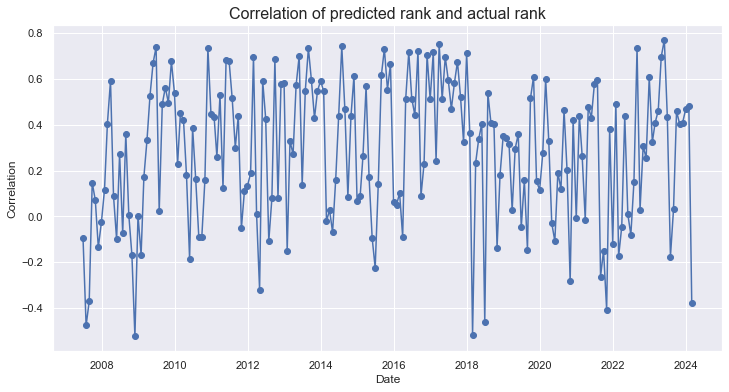

In [13]:
### analyze predict result ###
rank_predicted = predicted_returns.reset_index().pivot(index='date',columns='ticker',values='predicted_ret')
rank_predicted = rank_predicted.apply(lambda x:x.rank(),axis=1).T
rank_actual = ratio_new[['ret']].reset_index().pivot(index='date',columns='ticker',values='ret')
rank_actual = rank_actual.apply(lambda x:x.rank(),axis=1).iloc[1:].T

rank_corr = rank_predicted.corrwith(rank_actual).to_frame()

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
plt.plot(rank_corr.index, rank_corr[0], marker='o', linestyle='-', color='b')
plt.title('Correlation of predicted rank and actual rank', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.grid(True)
plt.show()

**Other models for generating predicted stock return (Machine Learning models)**

1. **Random Forests:** This ensemble method uses multiple decision trees to make predictions. It is effective in handling non-linear relationships and can provide insights into the importance of different factors.

2. **Gradient Boosting Machines (GBM):** GBM is another ensemble method that builds trees sequentially, with each tree trying to correct the errors of the previous one. It is known for its high accuracy and ability to handle various types of data.

3. **Support Vector Machines (SVM):** SVM can be used for regression tasks (SVR) and is effective in capturing complex relationships in high-dimensional spaces. It works well with both linear and non-linear data.

4. **Neural Networks:** Deep learning models, such as feedforward neural networks or recurrent neural networks (RNNs), can capture intricate patterns in time series data. They are particularly useful for modeling sequential data and can be trained to predict future returns based on past factor values.

5. **Lasso and Ridge Regression:** These are extensions of linear regression that include regularization terms to prevent overfitting and to handle multicollinearity. They can be useful when dealing with a large number of factors.

6. **XGBoost:** An implementation of gradient boosted trees designed for speed and performance, XGBoost is a popular choice for regression tasks and can handle missing data and various types of features.

## 4.2. Backtest

We adjust our position each month with new ranking:
1. [calc_position_by_rank()](src/trading_stratgy.py) first calculate ideal positions for all tickers in our valid universe by quantile. 
2. [CalcTrade()](src/trading_stratgy.py) iterate through each date and calculate adjusted position / PnL.

#### Position Change
To reduce to turnover rate, I only change position when ideal position has different sign from current open position, e.g.
- 100 (long) <-> 0
- -200 (short) <-> 0
- 100 (long) <-> -100 (short)
This would result in the initial equal long / short position went unbalance due to price movement. 

In final draft, we would like to include 
- additional execution constraint, e.g. maximum n ticker per sector
- remove holding constraint and try other allocation methods


#### Portfolio Allocation

I find tickers to buy and tickers to short at each rebalance date (weeks / months) by find top / botton a ~ b% quantile, and then simply allocated the assets by an 1/N rules. 

By DeMiguel, Garlappi, & Uppal (2009), this naive allocation strategy actually outperforms many optimization models derived from Markowitz initial mean-variance model due to the lower turnover and data scarcity. They also highlights a potential of constructing optimal portfolio with cross-sectional characteristics (Brandt, Santa-Clara, & Valkanov, 2007). 

In final draft, we would like to include 
- Markovitz allocation: we understand this probably won't work since our asset in holding are large (~40 long and 40 short) and our prediction horizon is too long to maintain a stable covariance matrix. But it would be nice to know exactly how it performance.
- CAPM allocation
- Factor allocation with our selected factor: this seems to be most prominent however it may lead to very similar results as 1/N portfolio since we also select holdings by factors.
- We won't try Black-Litterman despite its reputation since our portfolio won't hold any assets we perceived to have no information. 


#### Overfitting
Because both factor selection and stock ranking model are trained on entire sample period. Our backtest results are in-sample backtest, which makes it less reliable to draw any conclusion for future periods since it could be simply overfitting on the training samples. 

However, since our current models mostly reply on linear regressions and ranking correlation, which contains less parameter to overfit, we see the results is not showing extreme performance from this problem.

In final draft, we would like to include 
- a period by period train-test regime, e.g. using each of 2014 ~ 2024 as testing sets and train with only date before this period

In [14]:
pred = predicted_returns.unstack("ticker")
pred.shape

(201, 379)

In [15]:
INIT_CAPITAL = 2e7

position = calc_position_by_rank(
    df_price=price, 
    df_ratio=pred.apply(pd.to_numeric),
    rank_formula="predicted_ret",
    lb=0,
    ub=0.1,
    interval=None,
    use_change=False,
    position_size=INIT_CAPITAL / 20
)
position.head()


ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2007-06-30,0.0,1062.062532,8213.017475,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,-2577.388410,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
2007-07-31,0.0,-1140.390072,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,-2189.296812,0.000000,0.0,0.0,0.000000,0.0,-2005.048969,0.0,0.000000,0.0
2007-08-31,0.0,-1038.728040,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,867.450543,0.0,0.000000,0.0,834.794223,0.0
2007-09-30,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,-1374.701258,...,0.000000,-328.635790,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
2007-10-31,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,-632.631113,0.0,0.000000,...,1909.827662,-320.757325,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [16]:
pred.apply(pd.to_numeric)

predicted_ret                                                    \
ticker                 A       AAL      AAPL       ABT      ADBE       ADI   
date                                                                         
2007-06-30     -0.012380  0.003600  0.002501 -0.026493 -0.023899 -0.004848   
2007-07-31      0.015422 -0.024315 -0.007675 -0.002827 -0.001025  0.007581   
2007-08-31     -0.004328 -0.048138  0.029978 -0.033068 -0.002611  0.007610   
2007-09-30      0.009872  0.006801 -0.019709 -0.001654  0.019790 -0.002013   
2007-10-31     -0.022233 -0.013319 -0.068302 -0.061819 -0.102592 -0.008926   
...                  ...       ...       ...       ...       ...       ...   
2023-10-31      0.056875  0.029875 -0.180326  0.056972  0.047505  0.096993   
2023-11-30      0.068335  0.086031 -0.059106  0.052111 -0.001815  0.075281   
2023-12-31     -0.101753  0.039820  0.277051 -0.123747 -0.086941 -0.064320   
2024-01-31     -0.031198 -0.058402 -0.052649 -0.084413 -0.079611 -0.049419   
2024-02-29      0.018551  0.024069 -0.112007  0.030207  0.009602  0.014551   

                                                    ...                      \
ticker           ADM       ADP      ADSK       AEE  ...       FTV        LW   
date                                                ...                       
2007-06-30 -0.010975 -0.022466 -0.002302 -0.060594  ...       NaN       NaN   
2007-07-31 -0.002379  0.021641 -0.002774 -0.007705  ...       NaN       NaN   
2007-08-31  0.037497  0.037446  0.011353  0.055829  ...       NaN       NaN   
2007-09-30 -0.036845 -0.005075  0.013651 -0.015641  ...       NaN       NaN   
2007-10-31 -0.062527 -0.166606 -0.038149 -0.034634  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2023-10-31  0.068507  0.097945  0.028231  0.029096  ...  0.090463  0.036806   
2023-11-30 -0.000392  0.063897  0.117558  0.097130  ...  0.052667  0.078460   
2023-12-31  0.020665  0.034734 -0.150143  0.045604  ... -0.064210 -0.110180   
2024-01-31 -0.029002 -0.031461 -0.118330  0.022893  ... -0.039056 -0.005229   
2024-02-29 -0.035911 -0.009466 -0.023216 -0.016047  ... -0.004464 -0.037469   

                                                                        \
ticker            IR       DOW      UBER      CTVA       HWM      CARR   
date                                                                     
2007-06-30       NaN       NaN       NaN       NaN       NaN       NaN   
2007-07-31       NaN       NaN       NaN       NaN       NaN       NaN   
2007-08-31       NaN       NaN       NaN       NaN       NaN       NaN   
2007-09-30       NaN       NaN       NaN       NaN       NaN       NaN   
2007-10-31       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2023-10-31  0.080089  0.071363  0.020876  0.034279  0.082891  0.081508   
2023-11-30  0.069755  0.020682 -0.059401  0.025619  0.023735  0.010368   
2023-12-31 -0.192319 -0.123803  0.035894 -0.047591 -0.166842 -0.066960   
2024-01-31 -0.067738 -0.077258 -0.185228 -0.044002 -0.089060 -0.078143   
2024-02-29 -0.014096  0.001395  0.000829 -0.005922  0.017771  0.024902   

                                
ticker          ABNB       CEG  
date                            
2007-06-30       NaN       NaN  
2007-07-31       NaN       NaN  
2007-08-31       NaN       NaN  
2007-09-30       NaN       NaN  
2007-10-31       NaN       NaN  
...              ...       ...  
2023-10-31  0.026383  0.048010  
2023-11-30 -0.025260  0.086165  
2023-12-31  0.009526 -0.070276  
2024-01-31 -0.140492 -0.018080  
2024-02-29  0.003437 -0.106651  

[201 rows x 379 columns]

In [17]:
trade_cls = CalcTrade(
    df_price=price,
    init_cap=INIT_CAPITAL
)
summary_df = trade_cls.iter_dates(position=position)
summary_df.head()

,trading_cost,cash,long_position,short_position,position,interest,total,total_ret
2007-06-30,0.0,2.000000e+07,1.000000e+06,-1.000000e+06,5.820766e-11,0.000000,2.000000e+07,0.000000
2007-07-31,0.0,1.996332e+07,1.007689e+06,-1.009576e+06,-1.887635e+03,86071.633462,2.004750e+07,0.002375
2007-08-31,0.0,1.992398e+07,1.019323e+06,-1.023960e+06,-4.637764e+03,65128.260806,1.998447e+07,-0.000776
2007-09-30,0.0,1.986430e+07,1.017839e+06,-1.006967e+06,1.087239e+04,0.000000,1.987518e+07,-0.006241
2007-10-31,0.0,1.983795e+07,1.003082e+06,-1.016894e+06,-1.381118e+04,64517.602421,1.988866e+07,-0.005567


<Axes: title={'center': 'Entire Period Return'}>

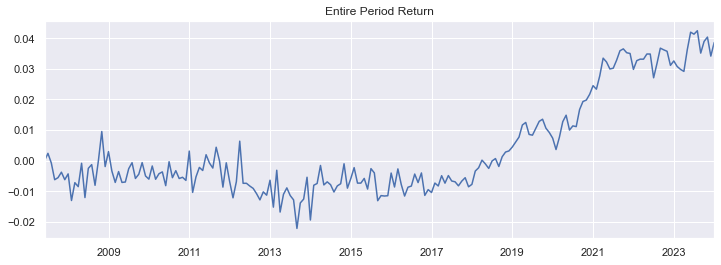

In [18]:
summary_df["total_ret"].plot(figsize=(12,4), title="Entire Period Return")

In [105]:
eval_return(summary_df["total_ret"], df_ff=df_ff, ann_factor=12)

{'return': -0.005721360756867355,
 'mean': 0.00015684129793331922,
 'std': 0.006653545625776077,
 'skew': -0.3450039951644571,
 'kurtosis': 2.0919294976706415,
 'sharpe': -0.0961808779709801,
 'sharpe_mkt': -0.0028767646990145016,
 'sortino': -0.13417628376876797,
 'var': -0.03998048097110849,
 'cvar': -0.053484044874800275,
 'max_drawdown': -0.08674940968747391,
 'downside_beta': 0.04980733450008458}

In [90]:
ff_decomposition(summary_df["total_ret"], df_ff=df_ff, ann_factor=12)

{'alpha': 0.26849876331756545,
 'beta_Mkt-RF': -0.08679973681958608,
 'beta_SMB': 0.23076508002672902,
 'beta_HML': -1.2277942658489065,
 'beta_RF': 189.86550471347445}